In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ADC/
#!unzip /content/drive/MyDrive/ADC/iec-algeria-data-cup-by-temtem-purchase-prediction-challenge.zip

/content/drive/MyDrive/ADC
Archive:  /content/drive/MyDrive/ADC/iec-algeria-data-cup-by-temtem-purchase-prediction-challenge.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: SampleSubmission.csv    


In [ ]:
#!pip install catboost

     |████████████████████████████████| 76.3 MB 59 kB/s 


# ALGERIA Data Cup by Temtem One Purchase Prediction Challenge by Industrial Engineers Club

Many shopping apps rely on customer retention to predict their earnings, design their marketing strategy and drive their business. Temtem One Shopping app is no different.

Being able to predict whether a customer will purchase again in the future is a great asset for e-commerce companies and doing so, will help Temtem improve it’s UX, it’s marketing strategy and make the whole purchasing experience better and faster.

The goal of this competition is to predict whether a customer will purchase again or not based on their purchase history in the Temtem shopping app from 1st of january (1/1/2021) up to (including) (15/02/2021) (around 45 days worth of data ). Your predictions will be then tested on real data from 15/02/2021 to 20/03/2021.

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten

import re

sns.set(style = 'white')

In [ ]:
Train = pd.read_csv('Train.csv')
Train.tail(5)

,Order ID,Order Status,Category Name,Product Name,Quantity,Unit Price,Total Price,Sub Total,Delivery Charge,Payment Method,Customer ID,Merchant,Order Time,Customer Country,Purchase Again
17756,8969960431,COMPLETED,Boeuf,Langue de veau 250 Gr,4,475,1900,12930,520520,CARD_PAY,3.560980e+09,21309099,2021-02-14 23:50:05,Algeria,1
17757,8969960431,COMPLETED,Boeuf,viande de veau avec os 500 Gr,2,905,1810,12930,520520,CARD_PAY,3.560980e+09,21309099,2021-02-14 23:50:05,Algeria,1
17758,8969960431,COMPLETED,Boeuf,Entrecote avec os 500 gr,2,1040,2080,12930,520520,CARD_PAY,3.560980e+09,21309099,2021-02-14 23:50:05,Algeria,1
17759,8969960431,COMPLETED,Boeuf,Cote de veau 1 kg,1,1920,1920,12930,520520,CARD_PAY,3.560980e+09,21309099,2021-02-14 23:50:05,Algeria,1
17760,8969960431,COMPLETED,Boeuf,Entrecote sans os 250 Gr,4,680,2720,12930,520520,CARD_PAY,3.560980e+09,21309099,2021-02-14 23:50:05,Algeria,1


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17761 entries, 0 to 17760
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order ID          17761 non-null  int64  
 1   Order Status      17761 non-null  object 
 2   Category Name     9093 non-null   object 
 3   Product Name      17761 non-null  object 
 4   Quantity          17761 non-null  int64  
 5   Unit Price        17761 non-null  object 
 6   Total Price       17761 non-null  object 
 7   Sub Total         17245 non-null  object 
 8   Delivery Charge   17731 non-null  object 
 9   Payment Method    17326 non-null  object 
 10  Customer ID       17263 non-null  float64
 11  Merchant          17761 non-null  int64  
 12  Order Time        17761 non-null  object 
 13  Customer Country  17714 non-null  object 
 14  Purchase Again    17761 non-null  int64  
dtypes: float64(1), int64(4), object(10)
memory usage: 2.0+ MB


In [ ]:
def Nan_check(Train):
  print(Train.isnull().sum()/Train.shape[0]*100)
Nan_check(Train)

Order ID             0.000000
Order Status         0.000000
Category Name       48.803558
Product Name         0.000000
Quantity             0.000000
Unit Price           0.000000
Total Price          0.000000
Sub Total            2.905242
Delivery Charge      0.168909
Payment Method       2.449186
Customer ID          2.803896
Merchant             0.000000
Order Time           0.000000
Customer Country     0.264625
Purchase Again       0.000000
dtype: float64


# Preparing the Data

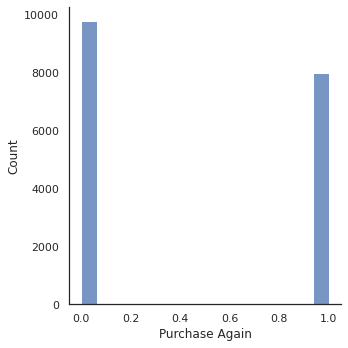

In [ ]:
sns.displot(Train['Purchase Again'])

In [ ]:
Train['Merchant'].value_counts()/Train.shape[0]*100

23255526          32.633298
6158523           19.970722
7225386           13.338213
7149870           12.510557
8065701            5.742920
7951146            2.466077
17654385           2.207083
10586352           1.660943
17934462           1.587748
8069691            1.249930
17021214           0.861438
21309099           0.805135
13688430           0.563031
17558898           0.551771
22538985           0.377231
22912617           0.365970
14379582           0.332189
22539111           0.332189
20152545           0.281516
19843719           0.185800
19380165           0.168909
22566453           0.152018
16194129           0.135128
22663767           0.129497
8333325            0.129497
16582167           0.123867
18310152           0.101346
16800798           0.078824
21926604           0.078824
17833536           0.073194
21057582           0.067564
20652072           0.067564
14700945           0.067564
19385436           0.061933
18118695           0.061933
15768564           0

In [ ]:
Merchants = Train['Merchant'].value_counts()
Merchnts = Merchants/Merchants.max()

def pre_01(Train, Merchants):
  Train['Order Time'] = pd.to_datetime(Train['Order Time'])
  Train['Hour'] = Train['Order Time'].dt.hour
  Train['Day'] = Train['Order Time'].dt.day
  Train['Week'] = Train['Order Time'].dt.dayofweek
  Train['weekend'] = Train['Order Time'].dt.day_name().isin(['Saturday', 'Friday', 'Thursday']).astype(int)
  Train['Best buyer'] = Train['Merchant'].isin([23255526, 6158523, 7225386, 7149870, 8065701]).astype(int)
  Train['Merchants'] = Train['Merchant'].map(Merchants)
  Train['Rush_hour'] = Train['Hour'].isin([10, 11, 12, 13, 14, 15, 16]).astype(int)
  return Train

Train = pre_01(Train, Merchants)
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17761 entries, 0 to 17760
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order ID          17761 non-null  int64         
 1   Order Status      17761 non-null  object        
 2   Category Name     9093 non-null   object        
 3   Product Name      17761 non-null  object        
 4   Quantity          17761 non-null  int64         
 5   Unit Price        17761 non-null  object        
 6   Total Price       17761 non-null  object        
 7   Sub Total         17245 non-null  object        
 8   Delivery Charge   17731 non-null  object        
 9   Payment Method    17326 non-null  object        
 10  Customer ID       17263 non-null  float64       
 11  Merchant          17761 non-null  int64         
 12  Order Time        17761 non-null  datetime64[ns]
 13  Customer Country  17714 non-null  object        
 14  Purchase Again    1776

In [ ]:
Train['Hour'].value_counts()

12    1561
14    1548
11    1322
10    1204
19    1203
15    1170
13    1031
16    1026
20     963
9      952
21     919
18     896
17     807
8      747
22     671
7      522
23     318
6      209
4      193
0      174
5      144
2       74
3       65
1       42
Name: Hour, dtype: int64

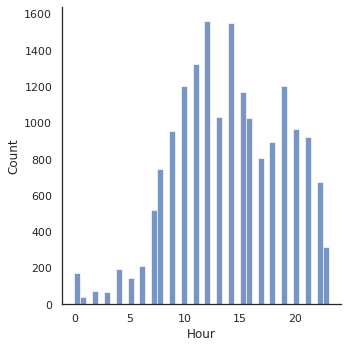

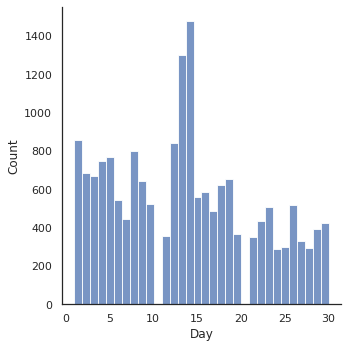

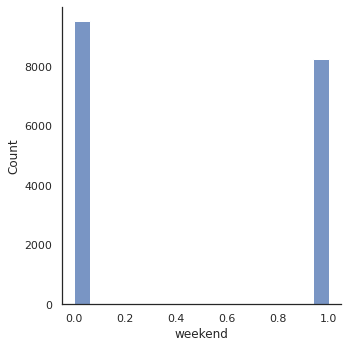

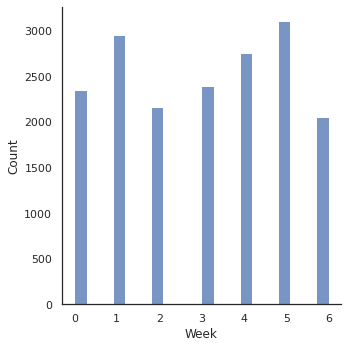

In [ ]:
sns.displot(Train, x= 'Hour')#, hue='Purchase Again')
sns.displot(Train, x= 'Day')
sns.displot(Train, x= 'weekend')
sns.displot(Train, x= 'Week') #0= Monday, 6=Sunday

In [ ]:
Train['Merchant'].value_counts()/Train.shape[0]*100

23255526          32.633298
6158523           19.970722
7225386           13.338213
7149870           12.510557
8065701            5.742920
7951146            2.466077
17654385           2.207083
10586352           1.660943
17934462           1.587748
8069691            1.249930
17021214           0.861438
21309099           0.805135
13688430           0.563031
17558898           0.551771
22538985           0.377231
22912617           0.365970
14379582           0.332189
22539111           0.332189
20152545           0.281516
19843719           0.185800
19380165           0.168909
22566453           0.152018
16194129           0.135128
22663767           0.129497
8333325            0.129497
16582167           0.123867
18310152           0.101346
16800798           0.078824
21926604           0.078824
17833536           0.073194
21057582           0.067564
20652072           0.067564
14700945           0.067564
19385436           0.061933
18118695           0.061933
15768564           0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


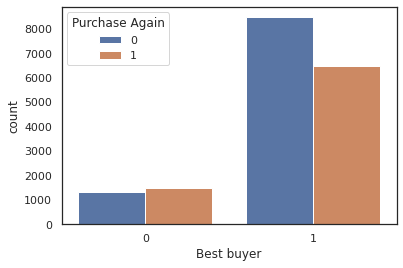

In [ ]:
sns.countplot(Train['Best buyer'], hue=Train["Purchase Again"])

In [ ]:
Train['Product Name'].value_counts()#/Train.shape[0]*100

2 Fardeaux Ifri                                                       173
03 fardeaux Ifri + 1 offert                                           156
03 Fardeaux Ifri + 1 Offert                                           133
IFRI eau minerale 1.5l x 6                                             99
SKOR sucre 5kg                                                         89
                                                                     ... 
AMIRAL optilla orange                                                   1
Sali's Pate Ã Â Tartiner au Miel de Dattes et aux Noisettes - 200G      1
kids                                                                    1
Fleurial moutarde fine de dijon verre 350g                              1
Bniwen                                                                  1
Name: Product Name, Length: 2917, dtype: int64

In [ ]:
Train['Category Name'][Train['Purchase Again']== 0 ].value_counts()

Pates et riz        417
Conserves           337
Promotions          321
Nettoyage           309
Legumes             299
                   ... 
Machine Ã cafe        1
Beaux arts            1
Dattes et figues      1
Lait infantile        1
Sauces                1
Name: Category Name, Length: 137, dtype: int64

In [ ]:
Cat_01 = Train['Category Name'][Train['Purchase Again']== 1 ].value_counts()/Train['Category Name'][Train['Purchase Again']== 1 ].value_counts().max()
Cat_00 = Train['Category Name'][Train['Purchase Again']== 0 ].value_counts()/Train['Category Name'][Train['Purchase Again']== 0 ].value_counts().max()

Products = Train['Product Name'].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)).lower()).value_counts()
print(Products)

Products = Products/Products.max()

def pre_02(Train, Cat_01, Cat_00, Products):
  
  Train["Cat0"] = Train['Category Name'].map(Cat_00)
  Train["Cat1"] = Train['Category Name'].map(Cat_01)

  Train["Product"] = Train['Product Name'].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)).lower())
  Train['Product'] = Train['Product'].map(Products)
  return Train
Train = pre_02(Train, Cat_01, Cat_00, Products)
Train.info()

fardeaux ifri offert                               289
skor sucre kg                                      287
elio l                                             231
fardeaux ifri                                      187
ifri eau minerale l x                              127
                                                  ... 
doppel herz zinc vit c histidine                     1
ariel machine g                                      1
fromage a tartiner sceaux kg                         1
serviettes hygieniques awane ado longues unites      1
force xpress anti tartre ml                          1
Name: Product Name, Length: 2264, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17761 entries, 0 to 17760
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order ID          17761 non-null  int64         
 1   Order Status      17761 non-null  object        
 2   Category Name     

In [ ]:
Train['Product'].value_counts()#/Train.shape[0]*100

0.003460    692
0.027682    640
0.006920    612
0.013841    592
0.017301    575
           ... 
0.221453     64
0.103806     60
0.197232     57
0.186851     54
0.173010     50
Name: Product, Length: 74, dtype: int64

In [ ]:
Train["Unit Price"].value_counts()

80       886
100      819
90       535
110      454
75       451
        ... 
3900       1
269        1
2.36       1
19000      1
880        1
Name: Unit Price, Length: 459, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


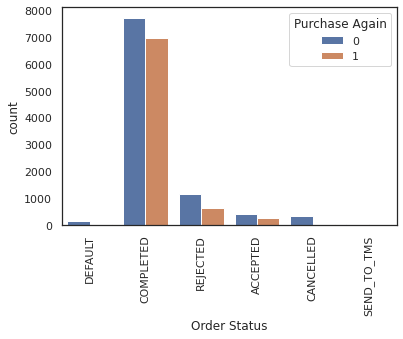

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


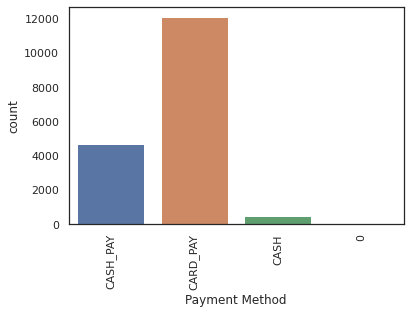

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


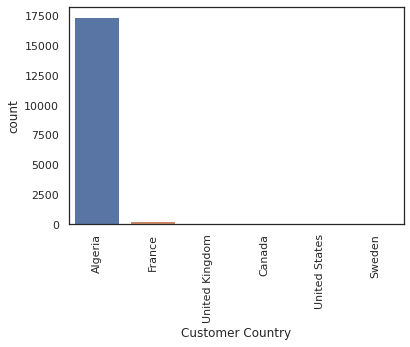

In [ ]:
sns.countplot(Train['Order Status'], hue = Train['Purchase Again'])
plt.tick_params(axis='x', rotation=90)
plt.show()

sns.countplot(Train['Payment Method'])#, hue = Train['Purchase Again'])
plt.tick_params(axis='x', rotation=90)
plt.show()

sns.countplot(Train['Customer Country'])#, hue = Train['Purchase Again'])
plt.tick_params(axis='x', rotation=90)
plt.show()

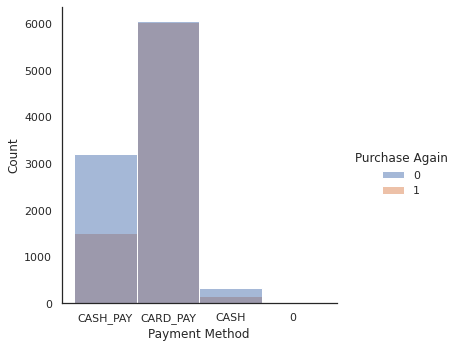

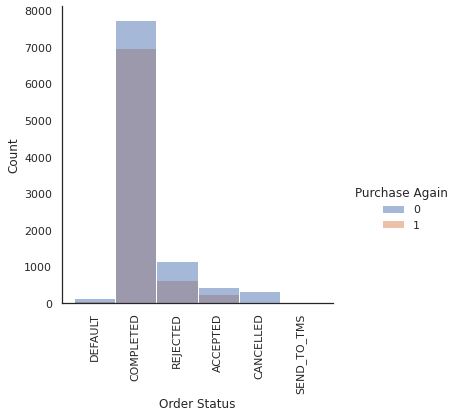

In [ ]:
sns.displot(Train, x= 'Payment Method', hue='Purchase Again')
plt.show()
sns.displot(Train, x= 'Order Status', hue='Purchase Again')
plt.tick_params(axis='x', rotation=90)


In [ ]:
Train['Order Status'].value_counts()/Train['Order Status'].value_counts().max()

COMPLETED      1.000000
REJECTED       0.120348
ACCEPTED       0.045241
CANCELLED      0.023811
DEFAULT        0.013266
SEND_TO_TMS    0.005647
Name: Order Status, dtype: float64

In [ ]:
Status = Train['Order Status'].value_counts()/Train['Order Status'].value_counts().max()
Payment = Train['Payment Method'].value_counts()/Train['Payment Method'].value_counts().max()

def pre_03(Train, Status, Payment):
  Train["Unit Price"] = pd.to_numeric(Train['Unit Price'].str.extract('(\d+)')[0])
  Train["Total Price"] = pd.to_numeric(Train["Total Price"].str.extract('(\d+)')[0])
  Train["Sub Total"] = pd.to_numeric(Train["Sub Total"].str.extract('(\d+)')[0])
  Train["Delivery Charge"] = pd.to_numeric(Train["Delivery Charge"].str.extract('(\d+)')[0])

  Train['Status'] = Train['Order Status'].map(Status)#Train['Order Status'].isin(['COMPLETED','ACCEPTED']).astype(int)#
  Train['Payment'] = Train['Payment Method'].map(Payment)#Train['Payment Method'].isin(['CARD_PAY']).astype(int)#

  Train['Country'] = Train['Customer Country'].isin(['Algeria']).astype(int)

  return Train

Train = pre_03(Train, Status, Payment)
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17761 entries, 0 to 17760
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order ID          17761 non-null  int64         
 1   Order Status      17761 non-null  object        
 2   Category Name     9093 non-null   object        
 3   Product Name      17761 non-null  object        
 4   Quantity          17761 non-null  int64         
 5   Unit Price        17761 non-null  int64         
 6   Total Price       17761 non-null  int64         
 7   Sub Total         17245 non-null  float64       
 8   Delivery Charge   17731 non-null  float64       
 9   Payment Method    17326 non-null  object        
 10  Customer ID       17263 non-null  float64       
 11  Merchant          17761 non-null  int64         
 12  Order Time        17761 non-null  datetime64[ns]
 13  Customer Country  17714 non-null  object        
 14  Purchase Again    1776

In [ ]:
Train.head()

,Order ID,Order Status,Category Name,Product Name,Quantity,Unit Price,Total Price,Sub Total,Delivery Charge,Payment Method,Customer ID,Merchant,Order Time,Customer Country,Purchase Again,Hour,Day,Week,weekend,Best buyer,Merchants,Rush_hour,Cat0,Cat1,Product,Status,Payment,Country
0,8236617,DEFAULT,Promotions,03 fardeaux Ifri + 1 offert,30,480,14400,43650.0,200200.0,CASH_PAY,8392354.0,6158523,2021-01-01 00:26:48,Algeria,1,0,1,4,1,1,3547,0,0.769784,0.519868,1.000000,0.013266,0.390093,1
1,8236617,DEFAULT,Promotions,3 fardeaux coca achetes = 1 fardeau offert,15,1800,27000,43650.0,200200.0,CASH_PAY,8392354.0,6158523,2021-01-01 00:26:48,Algeria,1,0,1,4,1,1,3547,0,0.769784,0.519868,0.145329,0.013266,0.390093,1
2,8236617,DEFAULT,Promotions,Snickers mini cube 200g,5,450,2250,43650.0,200200.0,CASH_PAY,8392354.0,6158523,2021-01-01 00:26:48,Algeria,1,0,1,4,1,1,3547,0,0.769784,0.519868,0.051903,0.013266,0.390093,1
3,8236624,COMPLETED,Paves,Pave chocolat,3,100,300,1460.0,700700.0,CARD_PAY,6359544.0,17654385,2021-01-01 00:27:29,Algeria,1,0,1,4,1,0,392,0,0.076739,0.105960,0.055363,1.000000,1.000000,1
4,8236624,COMPLETED,Tartes,Tarte citron,3,100,300,1460.0,700700.0,CARD_PAY,6359544.0,17654385,2021-01-01 00:27:29,Algeria,1,0,1,4,1,0,392,0,0.095923,0.122517,0.089965,1.000000,1.000000,1


In [ ]:
to_drop = ['Order ID', 'Order Status', 'Category Name', 'Product Name', 
       'Payment Method', 'Merchant', 'Order Time',
       'Customer Country']

Train.drop(to_drop, axis = 1, inplace= True)
Train.head()

,Quantity,Unit Price,Total Price,Sub Total,Delivery Charge,Customer ID,Purchase Again,Hour,Day,Week,weekend,Best buyer,Merchants,Rush_hour,Cat0,Cat1,Product,Status,Payment,Country
0,30,480,14400,43650.0,200200.0,8392354.0,1,0,1,4,1,1,3547,0,0.769784,0.519868,1.000000,0.013266,0.390093,1
1,15,1800,27000,43650.0,200200.0,8392354.0,1,0,1,4,1,1,3547,0,0.769784,0.519868,0.145329,0.013266,0.390093,1
2,5,450,2250,43650.0,200200.0,8392354.0,1,0,1,4,1,1,3547,0,0.769784,0.519868,0.051903,0.013266,0.390093,1
3,3,100,300,1460.0,700700.0,6359544.0,1,0,1,4,1,0,392,0,0.076739,0.105960,0.055363,1.000000,1.000000,1
4,3,100,300,1460.0,700700.0,6359544.0,1,0,1,4,1,0,392,0,0.095923,0.122517,0.089965,1.000000,1.000000,1


In [ ]:
Nan_check(Train)

Quantity            0.000000
Unit Price          0.000000
Total Price         0.000000
Sub Total           2.905242
Delivery Charge     0.168909
Customer ID         2.803896
Purchase Again      0.000000
Hour                0.000000
Day                 0.000000
Week                0.000000
weekend             0.000000
Best buyer          0.000000
Merchants           0.000000
Rush_hour           0.000000
Cat0               49.214571
Cat1               49.428523
Product             0.000000
Status              0.000000
Payment             2.449186
Country             0.000000
dtype: float64


In [ ]:
def pre_agg(Train, test = False):
  if test:
    Train = Train.groupby('Customer ID').agg({
        'Quantity': 'max',
        'Merchants': 'max',
        'Total Price': 'max',
        'Unit Price': 'max',
        'Sub Total':'max',         
        'Delivery Charge':'max',
        'Hour':'mean',
        'Day':'mean',
        'Week':'mean',
        'weekend':'mean',
        'Best buyer':'max',
        'Merchants':'max',
        'Cat0':'max',
        'Cat1':'max',
        'Product':'max',
        'Status':'max',
        'Payment':'max',
        'Rush_hour':'max'
  })
  else:
    Train = Train.groupby('Customer ID').agg({
        'Quantity': 'max',
        'Merchants': 'max',
        'Total Price': 'max',
        'Purchase Again' : 'max',
        'Unit Price': 'max',
        'Sub Total':'max',         
        'Delivery Charge':'max',
        'Hour':'mean',
        'Day':'mean',
        'Week':'mean',
        'weekend':'mean',
        'Best buyer':'max',
        'Merchants':'max',
        'Cat0':'max',
        'Cat1':'max',
        'Product':'max',
        'Status':'max',
        'Payment':'max',
        'Rush_hour':'max'
    })
  return Train

Train = pre_agg(Train)
Train.head()

,Quantity,Merchants,Total Price,Purchase Again,Unit Price,Sub Total,Delivery Charge,Hour,Day,Week,weekend,Best buyer,Cat0,Cat1,Product,Status,Payment,Rush_hour
Customer ID,,,,,,,,,,,,,,,,,,
1629574.0,2,5796,650,1,650,890.0,370370.0,12.600000,15.400000,4.200000,1.000000,1,NaN,NaN,0.647059,1.000000,0.390093,1
1735264.0,1,59,3990,0,3990,3990.0,150150.0,9.000000,11.000000,3.000000,1.000000,0,NaN,NaN,0.124567,0.120348,0.390093,0
1755078.0,4,5796,996,0,600,1625.0,200200.0,11.750000,15.250000,1.500000,0.000000,1,NaN,NaN,1.000000,1.000000,0.390093,1
1755834.0,200,5796,4800,1,2200,8800.0,640640.0,12.133333,6.266667,3.833333,0.833333,1,0.769784,0.953642,1.000000,1.000000,0.390093,1
1756892.0,1,5796,350,1,350,599.0,340340.0,18.000000,9.000000,4.500000,0.750000,1,NaN,NaN,0.647059,1.000000,0.390093,1


In [ ]:
X = Train.drop("Purchase Again", axis = 1)
y = Train['Purchase Again']

print(X.shape)
print(y.shape)

(999, 17)
(999,)


In [ ]:
imputer = KNNImputer()
imputer.fit(X)
def pre_nan(X):
  return pd.DataFrame(imputer.transform(X), columns= X.columns)
X = pre_nan(X)
Nan_check(X)

Quantity           0.0
Merchants          0.0
Total Price        0.0
Unit Price         0.0
Sub Total          0.0
Delivery Charge    0.0
Hour               0.0
Day                0.0
Week               0.0
weekend            0.0
Best buyer         0.0
Cat0               0.0
Cat1               0.0
Product            0.0
Status             0.0
Payment            0.0
Rush_hour          0.0
dtype: float64


In [ ]:
X.head()

,Quantity,Merchants,Total Price,Unit Price,Sub Total,Delivery Charge,Hour,Day,Week,weekend,Best buyer,Cat0,Cat1,Product,Status,Payment,Rush_hour
0,2.0,5796.0,650.0,650.0,890.0,370370.0,12.600000,15.400000,4.200000,1.000000,1.0,0.360671,0.440397,0.647059,1.000000,0.390093,1.0
1,1.0,59.0,3990.0,3990.0,3990.0,150150.0,9.000000,11.000000,3.000000,1.000000,0.0,0.008633,0.112583,0.124567,0.120348,0.390093,0.0
2,4.0,5796.0,996.0,600.0,1625.0,200200.0,11.750000,15.250000,1.500000,0.000000,1.0,0.655635,0.458278,1.000000,1.000000,0.390093,1.0
3,200.0,5796.0,4800.0,2200.0,8800.0,640640.0,12.133333,6.266667,3.833333,0.833333,1.0,0.769784,0.953642,1.000000,1.000000,0.390093,1.0
4,1.0,5796.0,350.0,350.0,599.0,340340.0,18.000000,9.000000,4.500000,0.750000,1.0,0.371703,0.450993,0.647059,1.000000,0.390093,1.0


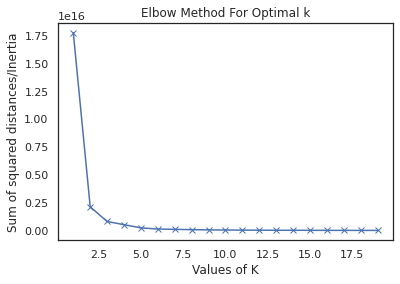

In [ ]:
Sum_of_squared_distances = []
K = range(1,20)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X)
  Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 31, random_state=0).fit(X)

In [ ]:
X['clusters'] = kmeans.predict(X)

# Modeling

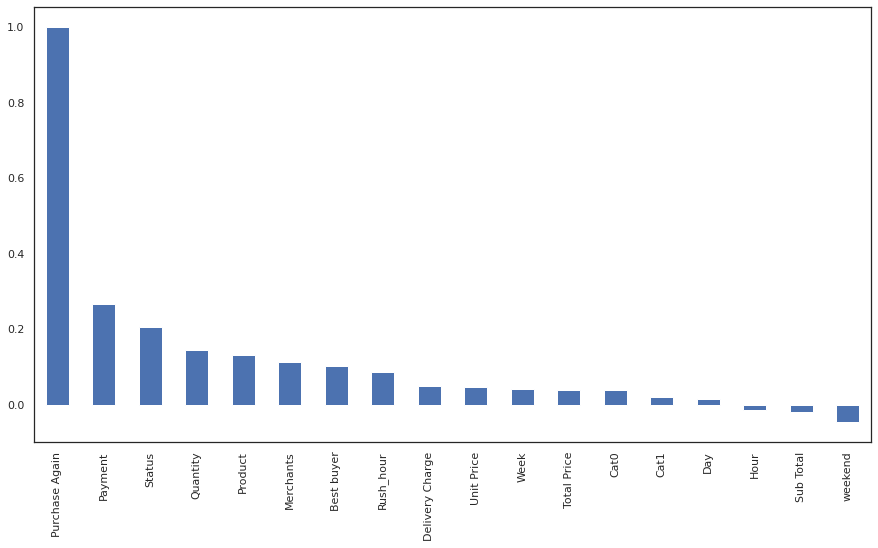

In [ ]:
plt.figure(figsize=(15,8))
Train.corr()['Purchase Again'].sort_values(ascending = False).plot(kind='bar')

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_ = scaler.transform(X)
X_

array([[-0.34105278,  1.13651442, -0.40463191, ..., -1.02041044,
         0.83087624,  1.81032053],
       [-0.44055971, -1.20816099,  0.13773315, ..., -1.02041044,
        -1.20354867, -0.8014037 ],
       [-0.14203892,  1.13651442, -0.34844678, ..., -1.02041044,
         0.83087624, -0.8014037 ],
       ...,
       [ 0.45500266,  1.13651442, -0.10584397, ..., -1.02041044,
        -1.20354867, -0.8014037 ],
       [ 2.44514126,  1.13651442, -0.21821422, ...,  0.8967609 ,
         0.83087624,  2.13678606],
       [-0.34105278,  1.13651442, -0.41973369, ..., -1.02041044,
         0.83087624, -0.8014037 ]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=100)
print("train size:", X_train.shape)
print("test size:", X_test.shape)

train size: (799, 18)
test size: (200, 18)


## CatBoost

In [ ]:
cb_clf = CatBoostClassifier(
    learning_rate=0.001, 
    loss_function='Logloss',
    verbose=False,
    subsample = 1,
    n_estimators= 60,
    depth = 6,
    l2_leaf_reg = 2
)

In [ ]:
kfold = KFold(n_splits=5)
results = cross_validate(cb_clf, X_, y, cv=kfold, scoring = 'roc_auc')
print("Accuracy: %.2f%% (%.2f%%)" % (results['test_score'].mean()*100, results['test_score'].std()*100))

Accuracy: 71.62% (3.42%)


In [ ]:
pd.DataFrame(results)

,fit_time,score_time,test_score
0,0.601524,0.009989,0.738241
1,0.345105,0.006361,0.739366
2,0.320158,0.005244,0.688107
3,0.498559,0.009521,0.663605
4,0.345936,0.006304,0.751613


In [ ]:
cb_clf.fit(X_train, y_train)

In [ ]:
y_pred = cb_clf.predict(X_test)

In [ ]:
print("train :",roc_auc_score(y_train, cb_clf.predict(X_train)))
print("test :",roc_auc_score(y_test, y_pred))

train : 0.6076509163039938
test : 0.5615261931051404


In [ ]:
grid = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200]
          #'ctr_border_count':[50,5,10,20,100,200]
        }

randomized_search_result = cb_clf.grid_search(grid,
                                                   X=X_,
                                                   y=y,
                                                   plot=False)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
bestTest = 0.5092767935
bestIteration = 97

7403:	loss: 0.5092768	best: 0.4687701 (490)	total: 1h 22m 12s	remaining: 11m 3s

bestTest = 0.5148254039
bestIteration = 496

7404:	loss: 0.5148254	best: 0.4687701 (490)	total: 1h 22m 12s	remaining: 11m 2s

bestTest = 0.6212338639
bestIteration = 499

7405:	loss: 0.6212339	best: 0.4687701 (490)	total: 1h 22m 12s	remaining: 11m 2s

bestTest = 0.5400252413
bestIteration = 499

7406:	loss: 0.5400252	best: 0.4687701 (490)	total: 1h 22m 12s	remaining: 11m 1s

bestTest = 0.5087087543
bestIteration = 454

7407:	loss: 0.5087088	best: 0.4687701 (490)	total: 1h 22m 12s	remaining: 11m

bestTest = 0.5048200822
bestIteration = 229

7408:	loss: 0.5048201	best: 0.4687701 (490)	total: 1h 22m 13s	remaining: 10m 59s

bestTest = 0.508068353
bestIteration = 84

7409:	loss: 0.5080684	best: 0.4687701 (490)	total: 1h 22m 13s	remaining: 10m 59s

bestTest = 0.5096071174
bestIteration = 997


CatBoostError: ignored

In [ ]:
pd.DataFrame(randomized_search_result)

## LR

In [ ]:
lr_clf = LogisticRegression(random_state=0,C= 100.0, penalty= 'l1', solver = 'liblinear')

In [ ]:
kfold = KFold(n_splits=5)
results = cross_validate(lr_clf, X_, y, cv=kfold, scoring = 'roc_auc')
print("Accuracy: %.2f%% (%.2f%%)" % (results['test_score'].mean()*100, results['test_score'].std()*100))

Accuracy: 71.14% (3.39%)


In [ ]:
lr_clf.fit(X_train, y_train)

LogisticRegression(C=100.0, penalty='l1', random_state=0, solver='liblinear')

In [ ]:
y_pred = lr_clf.predict(X_test)

In [ ]:
print("train :",roc_auc_score(y_train, lr_clf.predict(X_train)))
print("test :",roc_auc_score(y_test, y_pred))

train : 0.6025290878408384
test : 0.6264262053735739


In [ ]:
grid={'solver': ['newton-cg', 'lbfgs', 'liblinear'],"C":np.logspace(-3,3,7), "penalty":['none', 'l1', 'l2', 'elasticnet']}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=3)
logreg_cv.fit(X_,y)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.7207207207207208


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
126 fits failed out of a total of 252.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is 

## RF

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, 
                                criterion="gini", 
                                max_depth=9, 
                                min_samples_split=5, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0, 
                                max_features="auto", 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=None, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None, 
                                ccp_alpha=0, 
                                max_samples=None) 

In [ ]:
kfold = KFold(n_splits=3)
results = cross_val_score(rf_clf, X_, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 72.17% (6.14%)


In [ ]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0, max_depth=9, min_impurity_decrease=0,
                       min_samples_split=5, min_weight_fraction_leaf=0,
                       n_estimators=200)

In [ ]:
y_pred = rf_clf.predict(X_test)

In [ ]:
print("train :",roc_auc_score(y_train, rf_clf.predict(X_train)))
print("test :",roc_auc_score(y_test, y_pred))

train : 0.8914646060929035
test : 0.5879646669120354


In [ ]:
rf_clf.predict([X_train[0]])

array([1])

No handles with labels found to put in legend.


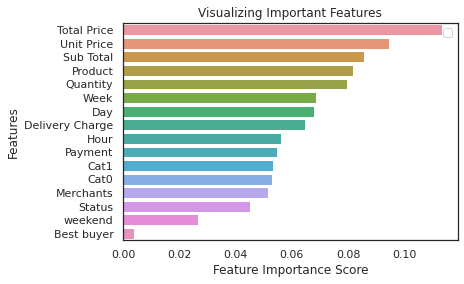

In [ ]:
feature_imp = pd.Series(rf_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## XGBoost

In [ ]:

params = {
            'objective':'binary:logistic',
            'max_depth': 9,
            'alpha': 10,
            'learning_rate': 0.3,
            'n_estimators':65,
          'subsample':0.1,
#          'gamma':10,
#'min_child_weight':9
        }  
xgb_clf = XGBClassifier(**params)

In [ ]:
kfold = KFold(n_splits=5)
results = cross_val_score(xgb_clf, X_, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 70.28% (5.16%)


In [ ]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, learning_rate=0.3, max_depth=9, n_estimators=65,
              subsample=0.1)

In [ ]:
y_pred = xgb_clf.predict(X_test)

In [ ]:
print("train :",roc_auc_score(y_train, xgb_clf.predict(X_train)))
print("test :",roc_auc_score(y_test, y_pred))

train : 0.7530087041477929
test : 0.6267329162066004


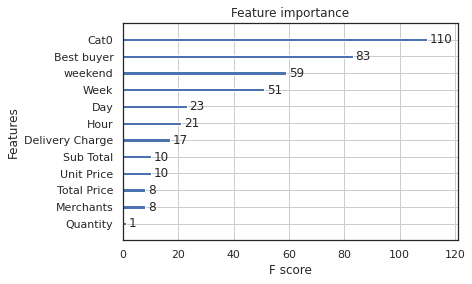

<Figure size 1152x864 with 0 Axes>

In [ ]:
xgb_clf.feature_names=X.columns
xgb.plot_importance(xgb_clf).set_yticklabels(X.columns)
plt.figure(figsize = (16, 12))
plt.show()

In [ ]:
grid = {#'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150]#,
              #'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              #'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]
        }
    
xgb_cv=GridSearchCV(xgb_clf,grid,cv=3, scoring = 'roc_auc', verbose = 2)
xgb_cv.fit(X_,y)

print("tuned hpyerparameters :(best parameters) ",xgb_cv.best_params_)
print("accuracy :",xgb_cv.best_score_)

Fitting 3 folds for each of 840 candidates, totalling 2520 fits
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=65; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=65; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=65; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=80; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=80; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=80; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=5, n

## NN

In [ ]:
X_train.shape

(7104, 16)

In [ ]:
acc_per_fold = []
loss_per_fold =[]
kfold = KFold(n_splits= 3, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_, y):

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[tf.keras.metrics.AUC()])
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(X_[train], y[train], epochs=50, batch_size=124, verbose=0)

  # Generate generalization metrics
  scores = model.evaluate(X_[test], y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  
  scores = model.evaluate(X_[train], y[train], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.470867395401001; auc_34 of 86.10894083976746%
Score for fold 1: loss of 0.46049362421035767; auc_34 of 86.68552041053772%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.46320194005966187; auc_35 of 86.88722848892212%
Score for fold 2: loss of 0.43305784463882446; auc_35 of 88.76389861106873%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.4375566244125366; auc_36 of 87.74045705795288%
Score for fold 3: loss of 0.41788020730018616; auc_36 of 89.27336931228638%


In [ ]:
model = Sequential()
model.add(Flatten())
model.add(layers.Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[tf.keras.metrics.AUC()])
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=124, verbose=1, validation_data=(X_test, y_test))#, callbacks = [es])

Epoch 1/50
7/7 [==============================] - 2s 69ms/step - loss: 0.7336 - auc_1: 0.4371 - val_loss: 0.7114 - val_auc_1: 0.4844
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 0.7032 - auc_1: 0.4448 - val_loss: 0.6951 - val_auc_1: 0.4939
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 0.6766 - auc_1: 0.4718 - val_loss: 0.6843 - val_auc_1: 0.4993
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6619 - auc_1: 0.4897 - val_loss: 0.6743 - val_auc_1: 0.5080
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6686 - auc_1: 0.4807 - val_loss: 0.6661 - val_auc_1: 0.5103
Epoch 6/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6572 - auc_1: 0.4952 - val_loss: 0.6587 - val_auc_1: 0.5146
Epoch 7/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6476 - auc_1: 0.5166 - val_loss: 0.6522 - val_auc_1: 0.5175
Epoch 8/50
7/7 [==============================] - 0s 10ms/step - loss: 

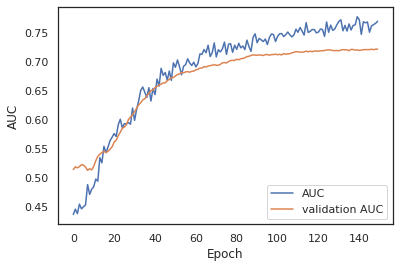

In [ ]:
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['val_auc'], label = 'validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.5396 - auc_1: 0.7000


# Submission

In [ ]:
Test = pd.read_csv("Test.csv")
Test.head()

,Order ID,Order Status,Category Name,Product Name,Quantity,Unit Price,Total Price,Sub Total,Delivery Charge,Payment Method,Customer ID,Merchant,Order Time,Customer Country
0,8236741,COMPLETED,Chocolat,NUTELLA 750g,2,1390,2780,4740,550550,CARD_PAY,8392444.0,7225386,2021-01-01 00:40:42,Algeria
1,8236741,COMPLETED,Chocolat,MILKA chocolat extra cacao 100g,1,210,210,4740,550550,CARD_PAY,8392444.0,7225386,2021-01-01 00:40:42,Algeria
2,8236741,COMPLETED,Chocolat,MILKA strawberry 100g,1,210,210,4740,550550,CARD_PAY,8392444.0,7225386,2021-01-01 00:40:42,Algeria
3,8236741,COMPLETED,Chocolat,LINDT les grandes noisette,1,900,900,4740,550550,CARD_PAY,8392444.0,7225386,2021-01-01 00:40:42,Algeria
4,8236741,COMPLETED,Boisson,IFRI eau minerale 1.5l x 6,2,170,340,4740,550550,CARD_PAY,8392444.0,7225386,2021-01-01 00:40:42,Algeria


In [ ]:
#Clients = Test['Customer ID'].unique()

In [ ]:
sub_df = pd.DataFrame()
sub_df['Customer'] = Test['Customer ID']

In [ ]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12013 entries, 0 to 12012
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order ID          12013 non-null  int64  
 1   Order Status      12013 non-null  object 
 2   Category Name     5999 non-null   object 
 3   Product Name      12013 non-null  object 
 4   Quantity          12013 non-null  int64  
 5   Unit Price        12013 non-null  object 
 6   Total Price       12013 non-null  object 
 7   Sub Total         11865 non-null  object 
 8   Delivery Charge   12012 non-null  object 
 9   Payment Method    11912 non-null  object 
 10  Customer ID       12013 non-null  float64
 11  Merchant          12013 non-null  int64  
 12  Order Time        12013 non-null  object 
 13  Customer Country  11981 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 1.3+ MB


In [ ]:
Nan_check(Test)

Order ID             0.000000
Order Status         0.000000
Category Name       50.062432
Product Name         0.000000
Quantity             0.000000
Unit Price           0.000000
Total Price          0.000000
Sub Total            1.231999
Delivery Charge      0.008324
Payment Method       0.840756
Customer ID          0.000000
Merchant             0.000000
Order Time           0.000000
Customer Country     0.266378
dtype: float64


In [ ]:
Test = pre_01(Test, Merchants)
Test = pre_02(Test,Cat_01,Cat_00,Products)
Test = pre_03(Test,Status,Payment)
Test.drop(to_drop, axis = 1, inplace= True)
Test = pre_agg(Test, test= True)
Clients = Test.index.tolist()
Test = pre_nan(Test)
Nan_check(Test)

kmeans_ = KMeans(n_clusters= 31).fit(Test)
Test['clusters'] = kmeans.predict(Test) 

print(Test.info())

scaler_ = StandardScaler().fit(Test)
Test = scaler_.transform(Test)


print(Test.shape)


Quantity           0.0
Merchants          0.0
Total Price        0.0
Unit Price         0.0
Sub Total          0.0
Delivery Charge    0.0
Hour               0.0
Day                0.0
Week               0.0
weekend            0.0
Best buyer         0.0
Cat0               0.0
Cat1               0.0
Product            0.0
Status             0.0
Payment            0.0
Rush_hour          0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Quantity         767 non-null    float64
 1   Merchants        767 non-null    float64
 2   Total Price      767 non-null    float64
 3   Unit Price       767 non-null    float64
 4   Sub Total        767 non-null    float64
 5   Delivery Charge  767 non-null    float64
 6   Hour             767 non-null    float64
 7   Day              767 non-null    float64
 8   Week             767 non

In [ ]:
sub = xgb_clf.predict(Test)

In [ ]:
#sub = model.predict(Test).flatten()

In [ ]:
sub = cb_clf.predict(Test)

In [ ]:
#sub = rf_clf.predict(Test)

In [ ]:
#sub = lr_clf.predict(Test)

In [ ]:
sub = dict(zip(Clients,sub))

In [ ]:
sub_df['Target'] = sub_df['Customer'].map(sub)
sub_df.head()

,Customer,Target
0,8392444.0,0
1,8392444.0,0
2,8392444.0,0
3,8392444.0,0
4,8392444.0,0


In [ ]:
"""
target = {}
for client in Clients:
  check = sub_df[sub_df['Customer']== client].mean()['Target']
  if check > 0.0:
    check = 0
  else:
    check= 1
  target[client] = check
sub_df['Target'] = sub_df['Customer'].map(target)
sub_df.head()
"""

"\ntarget = {}\nfor client in Clients:\n  check = sub_df[sub_df['Customer']== client].mean()['Target']\n  if check > 0.0:\n    check = 0\n  else:\n    check= 1\n  target[client] = check\nsub_df['Target'] = sub_df['Customer'].map(target)\nsub_df.head()\n"

In [ ]:
sub_df.to_csv('sub31.csv', index=False)